In [44]:
# 시뮬레이션 라이브러리 불러오기
import meep as mp
import meep.adjoint as mpa

import numpy as np
from matplotlib import pyplot as plt
from meep.materials import SiN

In [45]:
# 물질 설정 및 Refractive Index 설정
mp.verbosity(1)
um_scale = 1

# SiN = mp.Medium(index=2.0)
Air = mp.Medium(index=1.0)

In [46]:
resolution = 20 # 해상도
# design_region_width = 4 # 디자인 영역 x
design_region_width_y = 4 # 디자인 영역 y
design_region_height = 2 # 디자인 영역 높이 z
pml_size = 1.0 # PML 영역 크기

In [55]:
# 시뮬레이션 공간 설정
Sx = design_region_width
Sy = design_region_width_y
Sz = 2 * pml_size + design_region_height + 1 + 5
cell_size = mp.Vector3(Sx,)

In [56]:
pml_layers = [mp.PML(thickness = pml_size, direction = mp.Z)]

In [57]:
#simulation 1 : geometry가 없는 구조
geometry_1 = [
    mp.Block(
        center=mp.Vector3(0, 0, 0), size=mp.Vector3(y=Sy), material=Air
    )
]

In [58]:
fcen = (1/(0.40 * um_scale) + 1/(0.70 * um_scale))/2
df = 1 /(0.40 * um_scale) - 1/(0.70 * um_scale)
nfreq = 100

source_center = [0, 0, Sz / 2 - pml_size - 0.5] # Source 위치
source_size = mp.Vector3(0, Sy, 0)

src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)
source = [mp.Source(src, component=mp.Ex, size=source_size, center=source_center)]


In [79]:
sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry_1,
    sources=source,
    resolution=resolution,
    extra_materials=[SiN],
    k_point = mp.Vector3(0, 0, 0)
)


In [80]:
#reflection moniter 설정

refl_fr = mp.FluxRegion(
    center=mp.Vector3(0, 0, Sz/2 - pml_size - 0.3), size=mp.Vector3(0, Sy, 0)
) 
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

#transmission moiniter 설정

tran_t = mp.FluxRegion(
    center=mp.Vector3(0, 0, -Sz/2 + pml_size + 0.5), size=mp.Vector3(0, Sy, 0)
)
tran_total = sim.add_flux(fcen, df, nfreq, tran_t)


#pt는 transmitted flux region과 동일

pt = mp.Vector3(0, 0, -Sz/2 + pml_size + 0.5)


#source가 끝난 후에 50 동안 계속 실행하며 component는 Ey, pt 설계의 끝에서 |Ey|^2의 값이 최대 값으로부터 1/1000 만큼 감쇠할때까지
#추가적인 50 단위의 시간 실행 -> Fourier-transform 수렴예상

sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ex,pt,1e-5))

sim.plot2D(fields=mp.Ex)
plt.show()
#데이터 저장

straight_refl_data = sim.get_flux_data(refl)
total_flux = mp.get_fluxes(tran_total)
flux_freqs = mp.get_flux_freqs(tran_total)

-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 3D dimensions.
Computational cell is 0.05 x 0.05 x 4 with resolution 20
     block, center = (0,0,0)
          size (0,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.000454903 s
lorentzian susceptibility: frequency=5.23857, gamma=0.321009
-----------


RuntimeError: meep: Source width > cell width in y direction!


     block, center = (0,0,0)
          size (inf,4,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.32,2.32,2.32)


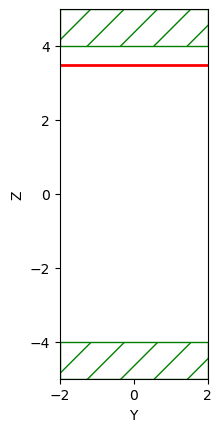

In [38]:
sim.reset_meep()

#simulation 2 : geometry가 있는 구조

geometry= [
    mp.Block(
        center=mp.Vector3(0, 0, 0), size=mp.Vector3(np.inf, Sy, 0.3 * um_scale), material=SiN
    )
]

sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    extra_materials=[SiN],
    k_point = mp.Vector3(0, 0, 0)
)
sim.plot2D()
plt.show()

In [39]:
# 반사된 flux 구하기

refl = sim.add_flux(fcen, df, nfreq, refl_fr)

# 투과된 flux 구하기

tran_fr = mp.FluxRegion(
    center=mp.Vector3(0, 0, -Sz/2 + pml_size + 0.5), size=mp.Vector3(0, Sy, 0)
)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

#반사된 필드와 입사되는 필드를 구분하기 위해서 The Fourier-transformed incident fields을
#the Fourier transforms of the scattered fields 에서 빼줍니다.

sim.load_minus_flux_data(refl, straight_refl_data)



-----------
Initializing structure...
time for choose_chunkdivision = 0.000111818 s
Working in 3D dimensions.
Computational cell is 0.05 x 4 x 10 with resolution 20
     block, center = (0,0,0)
          size (inf,4,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.32,2.32,2.32)
time for set_epsilon = 0.0230131 s
lorentzian susceptibility: frequency=5.23857, gamma=0.321009
-----------


field decay(t = 5.025): 5.606077029243847e-20 / 5.606077029243847e-20 = 1.0
field decay(t = 10.05): 0.0036002484371760726 / 0.0036002484371760726 = 1.0
field decay(t = 15.075000000000001): 0.2691202645040858 / 0.2691202645040858 = 1.0
field decay(t = 20.075000000000003): 9.564376392011577e-07 / 0.2691202645040858 = 3.5539413613597908e-06
run 0 finished at t = 20.075000000000003 (803 timesteps)
     block, center = (0,0,0)
          size (inf,4,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.32,2.32,2.32)


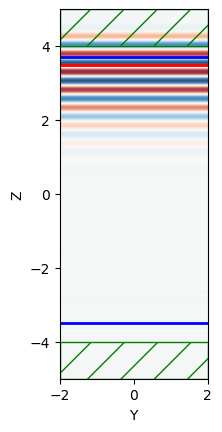

In [40]:
pt = mp.Vector3(0, 0, -Sz/2 + pml_size + 0.5) #pt는 transmitted flux region과 동일

sim.run(until_after_sources=mp.stop_when_fields_decayed(5,mp.Ex,pt,1e-5))

sim.plot2D(fields=mp.Ex)
plt.show()

#데이터 저장

bend_refl_flux = mp.get_fluxes(refl)
bend_tran_flux = mp.get_fluxes(tran)


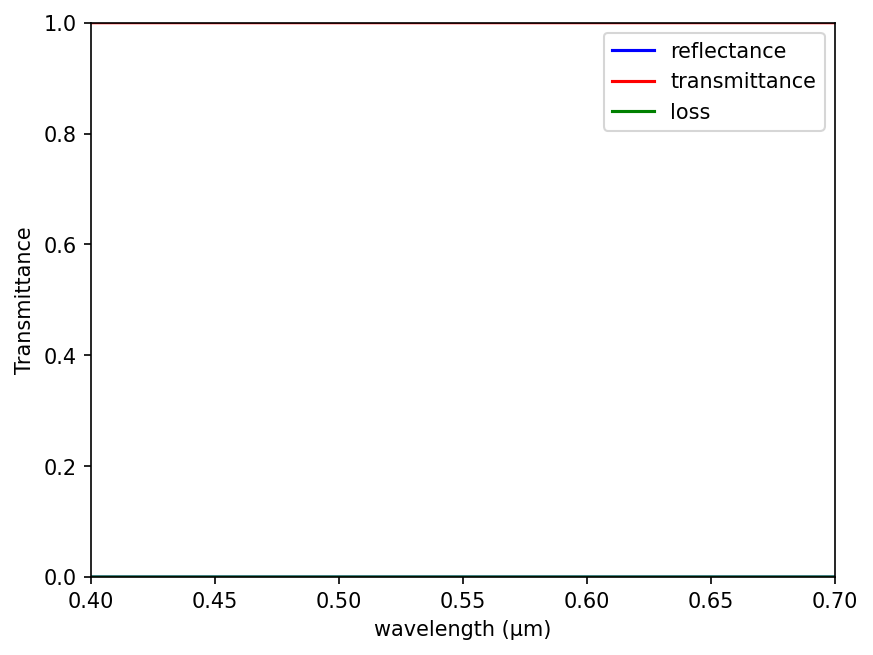

In [41]:
wl = []
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Rs = np.append(Rs, -bend_refl_flux[i] / total_flux[i])
    Ts = np.append(Ts, bend_tran_flux[i] / total_flux[i])

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Rs, "b", label="reflectance")
    plt.plot(wl, Ts, "r", label="transmittance")
    plt.plot(wl, 1 - Rs - Ts, "g", label="loss")
    plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.ylabel("Transmittance")
    plt.legend(loc="upper right")
    #plt.show()
    plt.savefig("Transmission2.png")

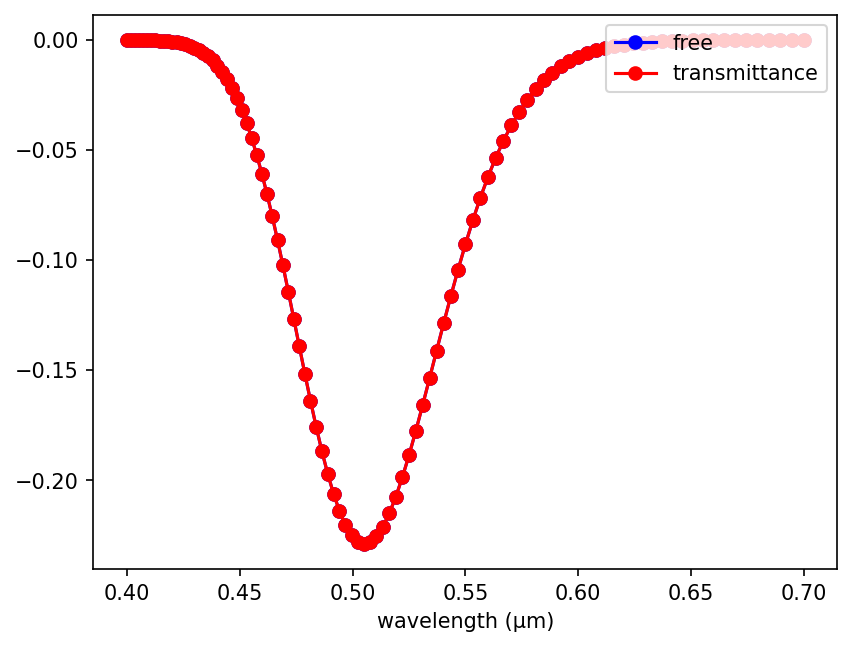

In [42]:
wl = [] #resolution 50
Rst = []
Tst = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Rst = np.append(Rst, total_flux[i])
    Tst = np.append(Tst, bend_tran_flux[i])

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Rst, "bo-", label="free")
    plt.plot(wl, Tst, "ro-", label="transmittance")
    # plt.plot(wl, 1 - Rs - Ts, "go-", label="loss")
    # plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.legend(loc="upper right")
    plt.show()

In [43]:
np.savetxt("Reflection_my_code.txt",Rs)
np.savetxt("Transmission_my_code.txt",Ts)